In [ ]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split


import numpy as np
import scipy.stats as stats
import seaborn as sns
# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
data= pd.read_csv(url)
data=data.drop('0',axis=1)
data['g']=data['g'].replace(['b','g'],[0,1])
### z-score all variables 

# find the columns we want to normalize 
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('g')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)


In [ ]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['g'].values ).float()
labels = labels[:,None] # transform to matrix

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets 
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)

In [ ]:
class ANNRadar_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(33,16)
    
    ### hidden layers
    self.fc1    = nn.Linear(16,16)
    self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
    self.fc2    = nn.Linear(16,16)
    self.bnorm2 = nn.BatchNorm1d(16) # the number of units into this layer

    ### output layer
    self.output = nn.Linear(16,1)
  
  # forward pass
  def forward(self,x,doBN):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )


    if doBN:
      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      x = self.fc1(x)    # weighted combination
      x = F.relu(x)      # activation function

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      x = self.fc2(x)    # weighted combination
      x = F.relu(x)      # activation function
    

    else:
      # hidden layer 1
      x = F.relu( self.fc1(x) )

      # hidden layer 2
      x = F.relu( self.fc2(x) )

    # output layer
    return self.output(x)

In [ ]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(LF,doBN=True):

  # loss function and optimizer
  lossfun = getattr(nn,LF)()
  optimizer = torch.optim.SGD(Radarnet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    Radarnet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = Radarnet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    ### test accuracy

    # NOTE: batch normalization should be turned off during testing, so we definitely need to switch modes here
    Radarnet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = Radarnet(X,doBN)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses,yHat

In [ ]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

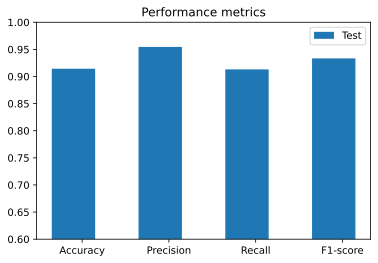

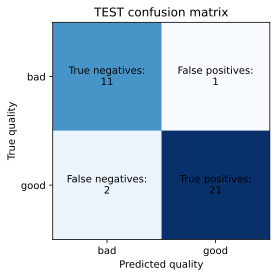

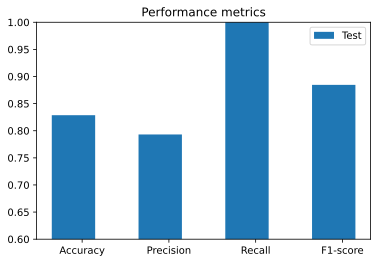

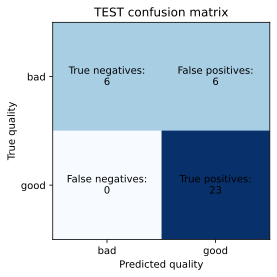

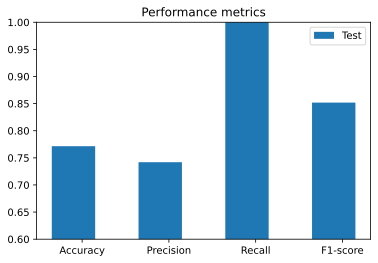

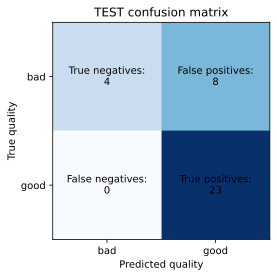

In [ ]:
import sklearn.metrics as skm
Loss_functions = ['BCEWithLogitsLoss','L1Loss','MSELoss']

trainByL = np.zeros((numepochs,len(Loss_functions)))
testByL = np.zeros((numepochs,len(Loss_functions)))
lossesByL=np.zeros((numepochs,len(Loss_functions)))

for ai,loss in enumerate(Loss_functions):
  # create a model and train it
  Radarnet = ANNRadar_withBNorm()
  trainacc,testacc,loss,yhat=trainTheModel(loss)
  trainByL[:,ai]=smooth(trainacc,10)
  testByL[:,ai]=smooth(testacc,10)
  lossesByL[:,ai]=smooth(loss,10)
  test_metrics  = [0,0,0,0]
  # test
  test_metrics[0] = skm.accuracy_score (test_labels,(yhat>0))
  test_metrics[1] = skm.precision_score(test_labels,(yhat>0))
  test_metrics[2] = skm.recall_score   (test_labels,(yhat>0))
  test_metrics[3] = skm.f1_score       (test_labels,(yhat>0))
  plt.bar(np.arange(4)-.1,test_metrics ,.5,label='Test')
  #plt.bar(np.arange(4)+.1,test_metrics,.5)
  plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
  plt.ylim([.6,1])
  plt.legend()
  plt.title('Performance metrics')
  testConf  = skm.confusion_matrix(test_labels,(yhat>0))
  fig,ax = plt.subplots(1,1,figsize=(10,4))
  # confmat during TEST
  ax.imshow(testConf,'Blues',vmax=len(yhat)/2)
  ax.set_xticks([0,1])
  ax.set_yticks([0,1])
  ax.set_xticklabels(['bad','good'])
  ax.set_yticklabels(['bad','good'])
  ax.set_xlabel('Predicted quality')
  ax.set_ylabel('True quality')
  ax.set_title('TEST confusion matrix')

  # add text labels
  ax.text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
  ax.text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
  ax.text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
  ax.text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')
  plt.show()


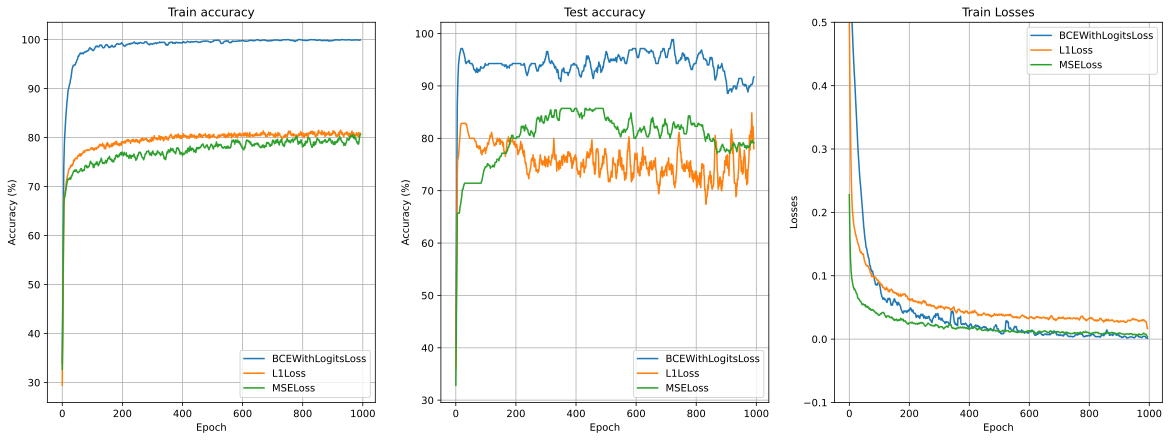

In [ ]:
# plot some results
fig,ax = plt.subplots(1,3,figsize=(20,7))

ax[0].plot(trainByL[:993])
ax[0].set_title('Train accuracy')
ax[1].plot(testByL[:993])
ax[1].set_title('Test accuracy')
ax[2].plot(lossesByL[5:])
ax[2].set_title('Train Losses')
# common features
for i in range(2):
  ax[i].legend(Loss_functions)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  #ax[i].set_ylim([50,100])
  ax[i].grid()
ax[2].legend(Loss_functions)
ax[2].set_xlabel('Epoch')
ax[2].set_ylim([-0.1,0.5])
ax[2].set_ylabel('Losses')
ax[2].grid()

plt.show()

In [ ]:
from google.colab import files
fig.savefig('Part4.png',bbox_inch='tight')
files.download("Part4.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>